# State goal: probabilistic interpretation of logistic regression.


In [5]:
import os
project_root = os.path.abspath("..")      # if notebook is in a subfolder
# or: project_root = os.path.abspath(".") if notebook is in repo root
if project_root not in sys.path:
    sys.path.append(project_root)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from optim import GradientDescent
from loss import LossFunction


np.random.seed(42)


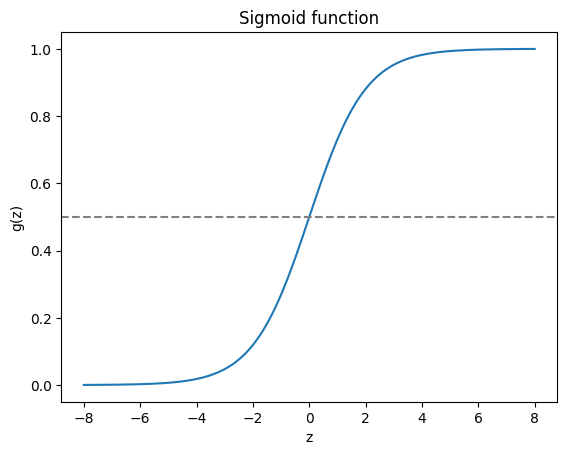

In [7]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

zs = np.linspace(-8, 8, 400)
gs = sigmoid(zs)

plt.plot(zs, gs)
plt.axhline(0.5, color="gray", linestyle="--")
plt.xlabel("z")
plt.ylabel("g(z)")
plt.title("Sigmoid function")
plt.show()


In [8]:
# Toy linearly separable-ish dataset
n = 200
X = np.random.randn(n, 2)
true_theta = np.array([-0.5, 2.0, -1.0])  # bias, w1, w2

Xb = np.c_[np.ones((n, 1)), X]
logits_true = Xb @ true_theta
probs_true = sigmoid(logits_true)
y = (probs_true > 0.5).astype(int)


In [9]:
def add_bias(X):
    return np.c_[np.ones((X.shape[0], 1)), X]

def log_likelihood(theta, X, y):
    Xb = add_bias(X)
    logits = Xb @ theta
    p = sigmoid(logits)
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))


Training with GD + loss classes

In [10]:
# We'll wrap the LossFunction methods for convenience

def logistic_loss_from_theta(theta, X, y):
    Xb = add_bias(X)
    p = sigmoid(Xb @ theta)
    return LossFunction.logistic_loss(p, y)

def logistic_grad_for_gd(y_pred_logits, y_true, Xb):
    # y_pred_logits is Xb @ theta (as gradient.py computes)
    p = sigmoid(y_pred_logits)
    return LossFunction.logistic_gradient(p, y_true, Xb)

theta_init = np.zeros(X.shape[1] + 1)

theta_gd = GradientDescent.batch(
    X,
    y,
    loss_fn=LossFunction.logistic_loss,
    loss_grad_fn=logistic_grad_for_gd,
    lr=0.1,
    n_iters=1000,
    tol=1e-6,
)

print("True θ:", true_theta)
print("GD θ  :", theta_gd)
print("Log-likelihood at GD θ:", log_likelihood(theta_gd, X, y))


True θ: [-0.5  2.  -1. ]
GD θ  : [-0.97688386  4.64425673 -2.62234379]
Log-likelihood at GD θ: -21.309688135544484


Accuracy / decision boundary:



In [11]:
def predict(theta, X, threshold=0.5):
    Xb = add_bias(X)
    p = sigmoid(Xb @ theta)
    return (p >= threshold).astype(int)

y_pred = predict(theta_gd, X)
acc = (y_pred == y).mean()
acc


0.99

### Likelihood vs loss

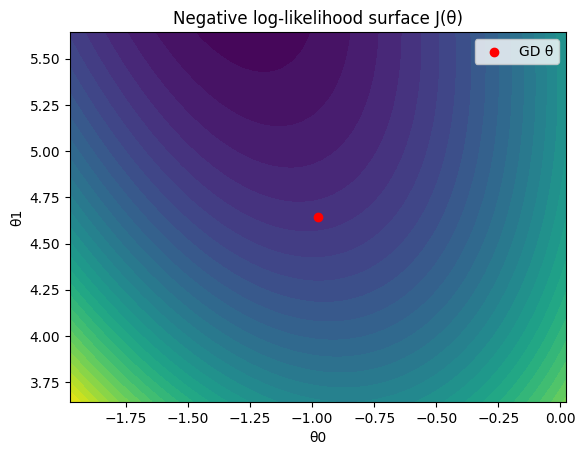

In [12]:
theta0_vals = np.linspace(theta_gd[0] - 1, theta_gd[0] + 1, 50)
theta1_vals = np.linspace(theta_gd[1] - 1, theta_gd[1] + 1, 50)

J_grid = np.zeros((len(theta0_vals), len(theta1_vals)))
LL_grid = np.zeros_like(J_grid)

for i, t0 in enumerate(theta0_vals):
    for j, t1 in enumerate(theta1_vals):
        theta_ij = np.array([t0, t1, theta_gd[2]])
        J_grid[i, j] = -log_likelihood(theta_ij, X, y) / len(y)
        LL_grid[i, j] = J_grid[i, j]

# contour plot of loss
T0, T1 = np.meshgrid(theta0_vals, theta1_vals, indexing="ij")
plt.contourf(T0, T1, J_grid, levels=30, cmap="viridis")
plt.scatter([theta_gd[0]], [theta_gd[1]], color="red", label="GD θ")
plt.xlabel("θ0")
plt.ylabel("θ1")
plt.title("Negative log-likelihood surface J(θ)")
plt.legend()
plt.show()


### NEWTON's METHOD

In [13]:
import numpy as np

def newton_logistic(X, y, n_iters=10, tol=1e-6, alpha=1.0):
    """
    Newton's method for logistic regression.

    θ^(t+1) = θ^(t) - α H^{-1} ∇J(θ^(t))

    J(θ) = -(1/n) Σ [ y log hθ(x) + (1-y) log(1-hθ(x)) ]
    ∇J(θ) = (1/n) Xᵀ (hθ(x) - y)
    H     = (1/n) Xᵀ R X, R = diag(p_i (1 - p_i))
    """
    Xb = add_bias(X)              # (n, d+1)
    n, d1 = Xb.shape
    theta = np.zeros(d1)

    thetas = [theta.copy()]
    losses = []

    for _ in range(n_iters):
        z = Xb @ theta
        p = sigmoid(z)

        # negative log-likelihood (average)
        loss = LossFunction.logistic_loss(p, y)
        losses.append(loss)

        # gradient and Hessian
        grad = Xb.T @ (p - y) / n               # (d+1,)
        r = p * (1 - p)                         # (n,)
        R = np.diag(r)
        H = Xb.T @ R @ Xb / n                   # (d+1, d+1)

        step = np.linalg.solve(H, grad)         # H step = grad
        theta_new = theta - alpha * step

        thetas.append(theta_new.copy())

        if np.linalg.norm(theta_new - theta) < tol:
            theta = theta_new
            break

        theta = theta_new

    return theta, np.array(thetas), np.array(losses)


### Running GD and Newton side by side

In [ ]:
# Gradient Descent 
def gd_logistic(X, y, lr=0.1, n_iters=200):
    Xb = add_bias(X)
    theta = np.zeros(Xb.shape[1])
    thetas = [theta.copy()]
    losses = []

    for _ in range(n_iters):
        logits = Xb @ theta
        p = sigmoid(logits)
        loss = LossFunction.logistic_loss(p, y)
        losses.append(loss)

        grad = LossFunction.logistic_gradient(p, y, Xb)
        theta = theta - lr * grad
        thetas.append(theta.copy())

    return theta, np.array(thetas), np.array(losses)

theta_gd, thetas_gd, losses_gd = gd_logistic(X, y, lr=0.1, n_iters=100)
theta_newton, thetas_newton, losses_newton = newton_logistic(X, y, n_iters=10, alpha=1.0)

theta_gd, theta_newton


(array([-0.38249063,  1.59856682, -0.95483771]),
 array([-17.58926482,  72.68422739, -34.43744849]))

### Visual comparison: loss vs iterations

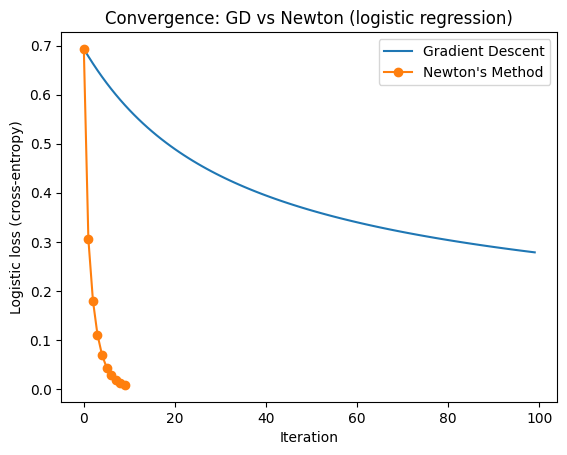

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses_gd, label="Gradient Descent")
plt.plot(losses_newton, label="Newton's Method", marker="o")
plt.xlabel("Iteration")
plt.ylabel("Logistic loss (cross-entropy)")
plt.title("Convergence: GD vs Newton (logistic regression)")
plt.legend()
plt.show()


### Visual comparison: decision boundaries

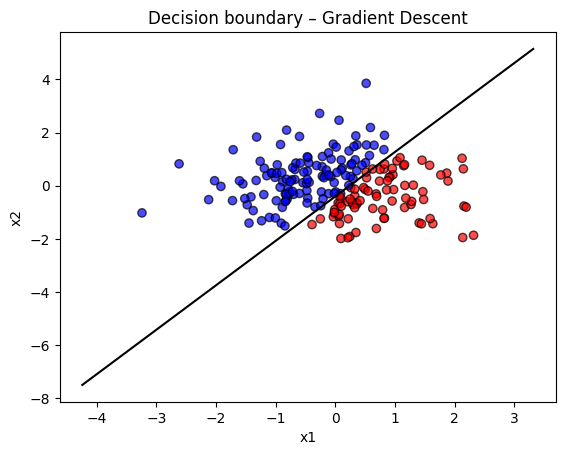

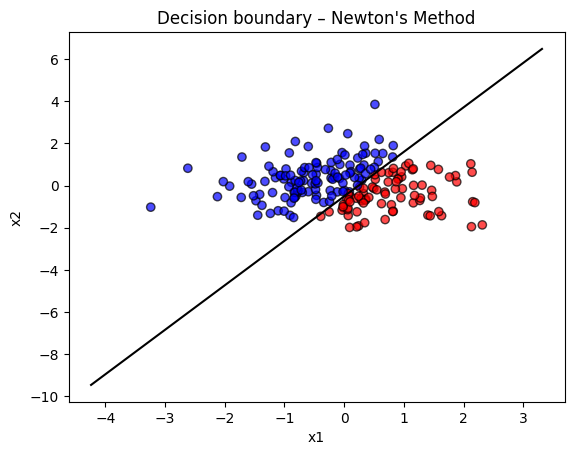

In [16]:
def plot_decision_boundary(theta, X, y, title):
    Xb = add_bias(X)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", alpha=0.7, edgecolor="k")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xs = np.linspace(x_min, x_max, 200)
    # θ0 + θ1 x1 + θ2 x2 = 0  ->  x2 = -(θ0 + θ1 x1) / θ2
    t0, t1, t2 = theta
    ys_line = -(t0 + t1 * xs) / t2

    plt.plot(xs, ys_line, color="black")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary(theta_gd, X, y, "Decision boundary – Gradient Descent")
plot_decision_boundary(theta_newton, X, y, "Decision boundary – Newton's Method")


### 2D parameter space trajectories


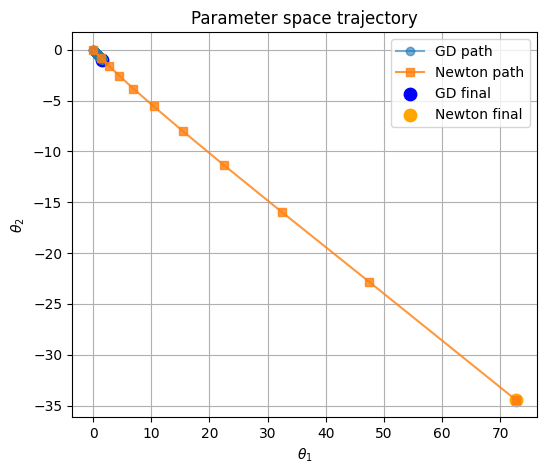

In [17]:
# Extract only (θ1, θ2) from history
theta1_gd, theta2_gd = thetas_gd[:, 1], thetas_gd[:, 2]
theta1_new, theta2_new = thetas_newton[:, 1], thetas_newton[:, 2]

plt.figure(figsize=(6, 5))
plt.plot(theta1_gd, theta2_gd, "-o", alpha=0.6, label="GD path")
plt.plot(theta1_new, theta2_new, "-s", alpha=0.8, label="Newton path")
plt.scatter([theta1_gd[-1]], [theta2_gd[-1]], c="blue", s=80, label="GD final")
plt.scatter([theta1_new[-1]], [theta2_new[-1]], c="orange", s=80, label="Newton final")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("Parameter space trajectory")
plt.legend()
plt.grid(True)
plt.show()


### Loss surface + paths (contours)


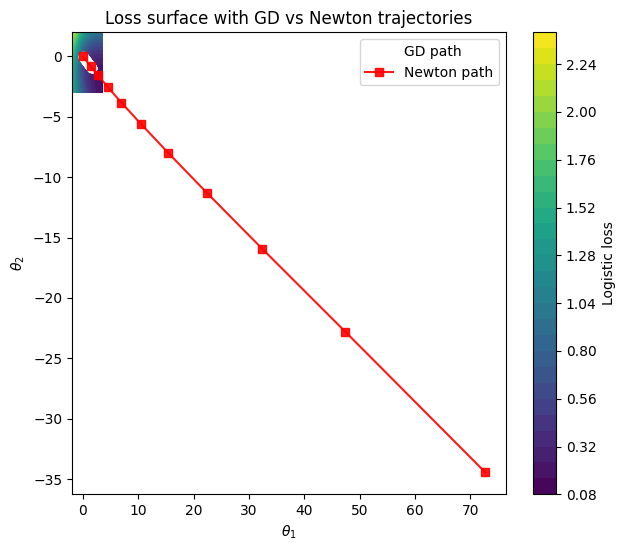

In [18]:
# Fix bias at GD final
theta0_fixed = theta_gd[0]

theta1_range = np.linspace(theta1_gd.min() - 2, theta1_gd.max() + 2, 80)
theta2_range = np.linspace(theta2_gd.min() - 2, theta2_gd.max() + 2, 80)

J = np.zeros((len(theta1_range), len(theta2_range)))

for i, t1 in enumerate(theta1_range):
    for j, t2 in enumerate(theta2_range):
        theta_tmp = np.array([theta0_fixed, t1, t2])
        Xb = add_bias(X)
        p = sigmoid(Xb @ theta_tmp)
        J[i, j] = LossFunction.logistic_loss(p, y)

T1, T2 = np.meshgrid(theta1_range, theta2_range, indexing="ij")

plt.figure(figsize=(7, 6))
cs = plt.contourf(T1, T2, J, levels=30, cmap="viridis")
plt.colorbar(cs, label="Logistic loss")

# overlay paths
plt.plot(theta1_gd, theta2_gd, "-o", color="white", alpha=0.8, label="GD path")
plt.plot(theta1_new, theta2_new, "-s", color="red", alpha=0.9, label="Newton path")

plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("Loss surface with GD vs Newton trajectories")
plt.legend()
plt.show()


### Margin / confidence histograms


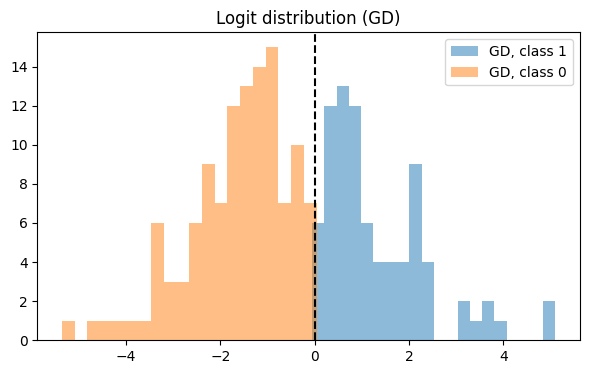

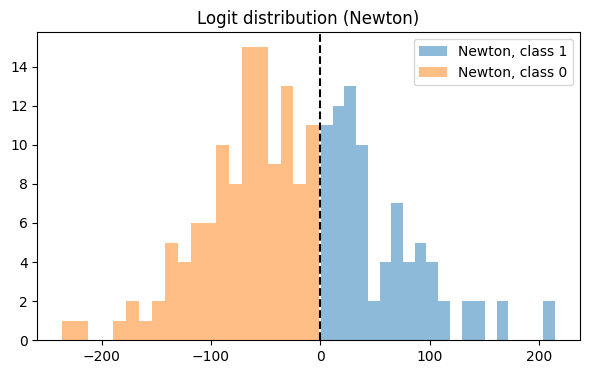

In [19]:
Xb = add_bias(X)
logits_gd = Xb @ theta_gd
logits_new = Xb @ theta_newton

plt.figure(figsize=(7,4))
plt.hist(logits_gd[y==1], bins=20, alpha=0.5, label="GD, class 1")
plt.hist(logits_gd[y==0], bins=20, alpha=0.5, label="GD, class 0")
plt.axvline(0, color="k", linestyle="--")
plt.title("Logit distribution (GD)")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(logits_new[y==1], bins=20, alpha=0.5, label="Newton, class 1")
plt.hist(logits_new[y==0], bins=20, alpha=0.5, label="Newton, class 0")
plt.axvline(0, color="k", linestyle="--")
plt.title("Logit distribution (Newton)")
plt.legend()
plt.show()


### Time vs iterations


In [20]:
import time

start = time.time()
theta_gd, _, _ = gd_logistic(X, y, lr=0.1, n_iters=200)
t_gd = time.time() - start

start = time.time()
theta_newton, _, _ = newton_logistic(X, y, n_iters=10, alpha=1.0)
t_new = time.time() - start

print(f"GD:     {len(losses_gd)} iters, {t_gd:.4f} s")
print(f"Newton: {len(losses_newton)} iters, {t_new:.4f} s")


GD:     100 iters, 0.0095 s
Newton: 10 iters, 0.0010 s


for inverse hessian method  Time Complexity is O(d³) per step, tho less no of steps than GD
few Newton steps but expensive